In [9]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from natasha import Segmenter, MorphVocab, NewsNERTagger, NewsEmbedding, NewsMorphTagger, Doc
from utils.trajectories import trajectory_from_text
from utils.ordec import entropy_complexity
from utils.ordec_borders import *
import warnings
warnings.filterwarnings("ignore")

wdict = np.load('russian_dict.npy', allow_pickle=True).item()
# wdict = {word: vec[-8:] for word, vec in wdict.items()}

In [10]:
import nolds

def split_text(text, num_parts):
    words = text.split()
    part_size = len(words) // num_parts
    parts = []
    for i in range(num_parts):
        start = i * part_size
        end = (i + 1) * part_size if i < num_parts - 1 else None
        parts.append(" ".join(words[start:end]))
    return parts

n, m = 3, 4

lemma_jokes = open('anekdots_trunc.txt', 'r').read()
jokes = lemma_jokes.split('\n\n')

with open('lemma_literature.txt', 'r', encoding='utf-8') as f:
    text = f.read()
num_parts = 60000 #len(jokes)
parts = split_text(text, num_parts)

def calculate_lyapunov_exponent(trajectory):
    try:
        if trajectory.ndim > 1:
            trajectory = np.linalg.norm(trajectory, axis=1)
        lyap = nolds.lyap_e(trajectory)
        return lyap[0]
    except Exception as e:
        return None

results_liter_lots_with_lyap = []
for i, part in enumerate(tqdm(parts, desc="Processing literature parts for Lyapunov")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        lyap = calculate_lyapunov_exponent(ts)
        results_liter_lots_with_lyap.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'lyapunov': lyap,
            'text_type': 'literature',
            'lang': 'ru',
            'n': n,
            'm': m
        })

results_df_liter_lots_with_lyap = pd.DataFrame(results_liter_lots_with_lyap)

results_jokes_with_lyap = []
for i, part in enumerate(tqdm(jokes, desc="Processing jokes parts for Lyapunov")):
    ts = trajectory_from_text(part, wdict, m)
    if ts is not None:
        ent, comp = entropy_complexity(ts, n=n, m=m)
        lyap = calculate_lyapunov_exponent(ts)
        results_jokes_with_lyap.append({
            'part': i + 1,
            'entropy': ent,
            'complexity': comp,
            'lyapunov': lyap,
            'text_type': 'jokes',
            'lang': 'ru',
            'n': n,
            'm': m
        })

results_df_jokes_with_lyap = pd.DataFrame(results_jokes_with_lyap)

Processing literature parts for Lyapunov:   0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

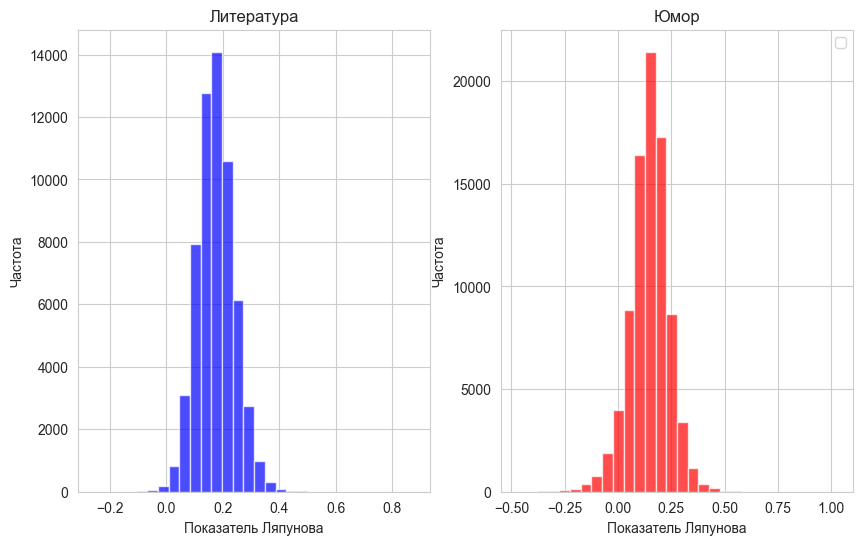

In [11]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
literature_lyap = results_df_liter_lots_with_lyap['lyapunov'].dropna()
plt.hist(literature_lyap, bins=30, color='blue', alpha=0.7)
plt.title("Литература")
plt.xlabel("Показатель Ляпунова")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
jokes_lyap = results_df_jokes_with_lyap['lyapunov'].dropna()
plt.hist(jokes_lyap, bins=30, color='red', alpha=0.7)
plt.title("Юмор")
plt.xlabel("Показатель Ляпунова")
plt.ylabel("Частота")

plt.legend()
plt.show()